# Exploratory Data Analysis (EDA) on Economic Indicator
Created on February 24th, 2023. 

In this notebook, we will perform the EDA on the time series dataset. There are 3 steps:
1. Installation Libraries
2. Dataset Preparation
3. EDA

##1. Installation Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from functools import reduce

## 2. Dataset Preparation
To run the shared colab notebook for the first time, files are allocated differently from the Drive owner's. Changing a directory is necessary prior to importing the dataset, and these are the processes:
1. Right click to the `DataTeam1` folder, select `Add shortcut to Drive`, and then `My Drive`.
2. Upload Dataset file to the `IndexK` folder.
3. Do read_csv on your Dataset file.

In [2]:
import_df = pd.read_csv('../../Datasets/T10Y2Y.csv') #Dataset file
import_df.head(5)

,DATE,T10Y2Y
0,1976-06-01,0.68
1,1976-06-02,0.71
2,1976-06-03,0.70
3,1976-06-04,0.77
4,1976-06-07,0.79


In [3]:
recession = pd.read_csv('../../Datasets/Recession.csv')
recession.head(5)

,DATE,JHDUSRGDPBR
0,1967-10-01,0.0
1,1968-01-01,0.0
2,1968-04-01,0.0
3,1968-07-01,0.0
4,1968-10-01,0.0


## 3. EDA
The analysis can be conducted at any timeline frequency, including, daily, weekly, and monthly. You can select any methods for analysis, in which the keyword for searching is 'Time series analysis'. 

To-do tasks:
1. Visualize the output
2. Discuss/analyze the result

Update meeting on March 2nd, 2023.

In [4]:
df = import_df.copy()
df['DATE'] = pd.to_datetime(df['DATE'])
df.columns = ['DATE', 'T10Y2Y']
df["T10Y2Y"] = pd.to_numeric(df['T10Y2Y'], errors='coerce')
df.set_index('DATE', inplace=True)
df

,T10Y2Y
DATE,
1976-06-01,0.68
1976-06-02,0.71
1976-06-03,0.70
1976-06-04,0.77
1976-06-07,0.79
...,...
2023-02-22,-0.73
2023-02-23,-0.78
2023-02-24,-0.83


In [5]:
recession.columns = ['DATE', 'recession']
recession['DATE'] = pd.to_datetime(recession['DATE'])
start = []
end = []
for i, date in enumerate(recession.DATE):
  if i == 0 or i==len(recession.DATE)-1:
    continue
  if (recession.recession[i-1] == 0) & (recession.recession[i] == 1):
    start.append(date)
  elif (recession.recession[i] == 1) & (recession.recession[i+1] == 0):
    end.append(date)
print(start)
print(end)

[Timestamp('1969-04-01 00:00:00'), Timestamp('1973-10-01 00:00:00'), Timestamp('1979-04-01 00:00:00'), Timestamp('1981-04-01 00:00:00'), Timestamp('1989-10-01 00:00:00'), Timestamp('2001-01-01 00:00:00'), Timestamp('2007-10-01 00:00:00'), Timestamp('2020-01-01 00:00:00')]
[Timestamp('1970-10-01 00:00:00'), Timestamp('1975-01-01 00:00:00'), Timestamp('1980-04-01 00:00:00'), Timestamp('1982-04-01 00:00:00'), Timestamp('1991-01-01 00:00:00'), Timestamp('2001-07-01 00:00:00'), Timestamp('2009-04-01 00:00:00'), Timestamp('2020-04-01 00:00:00')]


In [6]:
start = start[2:]
end = end[2:]
Reces = pd.DataFrame()
Reces['start'] = start
Reces['end'] = end
Reces

,start,end
0,1979-04-01,1980-04-01
1,1981-04-01,1982-04-01
2,1989-10-01,1991-01-01
3,2001-01-01,2001-07-01
4,2007-10-01,2009-04-01
5,2020-01-01,2020-04-01


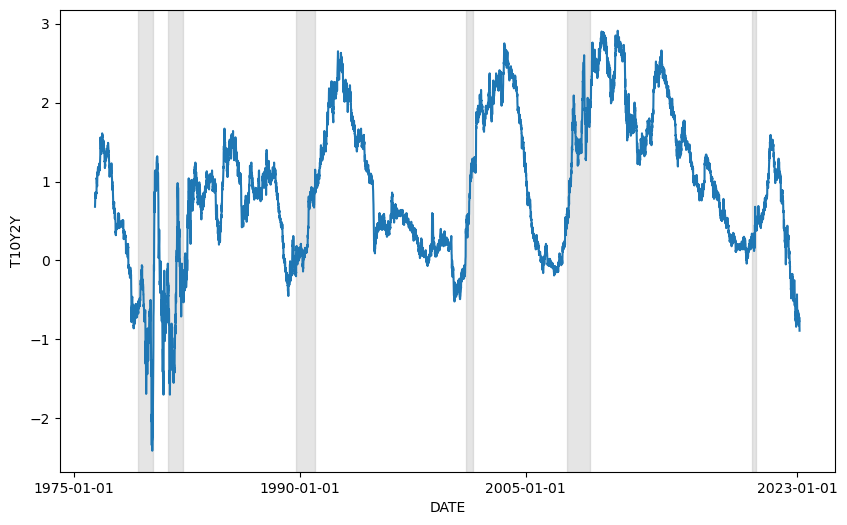

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='DATE', y='T10Y2Y', data=df)
for i in range(len(start)):
  ax.axvspan(start[i], end[i], color='grey', alpha=0.2)

plt.xticks(['1975-01-01','1990-01-01', '2005-01-01', '2023-01-01'])
plt.show()

In [7]:
def calc_TP_FP_rate(y_true, y_pred):
    
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_true.index: 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_true[i]!=y_pred[i]:
           FN += 1
    
    # Calculate true positive rate and false positive rate
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)

    return tpr, fpr

In [21]:
dfi = df.copy()
dfi.index = dfi.index + dt.timedelta(days=1*30)

dfi['MIN_1Y'] = np.nan
for i in range(len(dfi)):
    if i >= 365:
        arr = np.array(dfi['T10Y2Y'])
        indices = [i-k for k in range(365)]
        take = np.take(arr, indices)
        dfi.iloc[i,1] = take[~np.isnan(take)].min()
    else:
        dfi.iloc[i,1] = np.nan

dfi['CHG'] = (dfi['T10Y2Y'])/dfi['MIN_1Y']
dfi

,T10Y2Y,MIN_1Y,CHG
DATE,,,
1976-07-01,0.68,NaN,NaN
1976-07-02,0.71,NaN,NaN
1976-07-03,0.70,NaN,NaN
1976-07-04,0.77,NaN,NaN
1976-07-07,0.79,NaN,NaN
...,...,...,...
2023-03-24,-0.73,-0.84,0.869048
2023-03-25,-0.78,-0.84,0.928571
2023-03-26,-0.83,-0.84,0.988095


In [31]:
tot = []

for shift in range(1,7):
  dfi = df.copy()
  dfi.index = dfi.index + dt.timedelta(days=shift*30)

  dfi['MIN_1Y'] = np.nan
  for i in range(len(dfi)):
    if i >= 365:
      arr = np.array(dfi['T10Y2Y'])
      indices = [i-k for k in range(365)]
      take = np.take(arr, indices)
      dfi.iloc[i,1] = take[~np.isnan(take)].min()
    else:
      dfi.iloc[i,1] = np.nan

  dfi['CHG'] = (dfi['T10Y2Y'])/dfi['MIN_1Y']
  li = []
  for i in range(len(Reces)):
    li.append(dfi.reset_index()['DATE'].apply(lambda x: int((x > Reces.loc[i]['start'])&(x < Reces.loc[i]['end']))))
  test = reduce(lambda x,y:x+y, li)
  dfi['recession'] = test.values.copy()
  # Containers for true positive / false positive rates
  tp_rates = []
  fp_rates = []

  threshold = np.linspace(-20,20,num=75)

  # Find true positive / false positive rate for each threshold
  for t in threshold:
      
      dfi['predict'] = dfi['CHG'].apply(lambda x: int(x<t))
      tp_rate, fp_rate = calc_TP_FP_rate(dfi['recession'], dfi['predict'])
          
      tp_rates.append(tp_rate)
      fp_rates.append(fp_rate)
  
  tot.append([fp_rates, tp_rates])

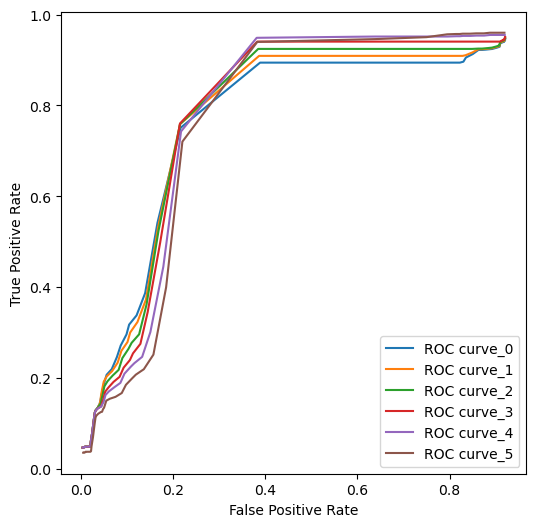

In [32]:
fig, ax = plt.subplots(figsize=(6,6))
for i in range(len(tot)):
  ax.plot(tot[i][0], tot[i][1], label=f'ROC curve_{i}')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

auc score for 1 month(s) prediction 0.6957237714922522
auc score for 2 month(s) prediction 0.7026810947167799
auc score for 3 month(s) prediction 0.708341593387107
auc score for 4 month(s) prediction 0.7138160604025363
auc score for 5 month(s) prediction 0.7109227248694088
auc score for 6 month(s) prediction 0.6969840627512929


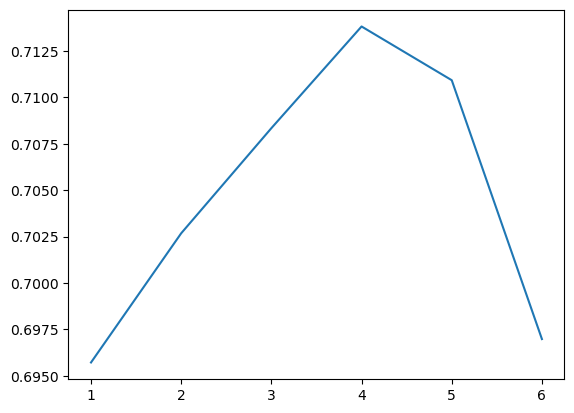

In [37]:
from sklearn.metrics import auc
auc_x = []
auc_y = []
for i in range(len(tot)):
  auc_x.append(i+1)
  auc_y.append(auc(tot[i][0], tot[i][1]))
  print(f'auc score for {i+1} month(s) prediction {auc_y[i]}')
plt.plot(auc_x, auc_y)

In [41]:
temp = pd.DataFrame()
temp['False positive'] = tot[3][0]
temp['True positive'] = tot[3][1]
temp[20:40]

,False positive,True positive
20,0.027587,0.109091
21,0.029630,0.123776
22,0.031581,0.127972
23,0.035668,0.132168
24,0.041055,0.135664
25,0.043563,0.137762
26,0.045421,0.145455
27,0.047464,0.151049
28,0.051923,0.169231
29,0.058889,0.178322


final threshold: 0.5405405405405403


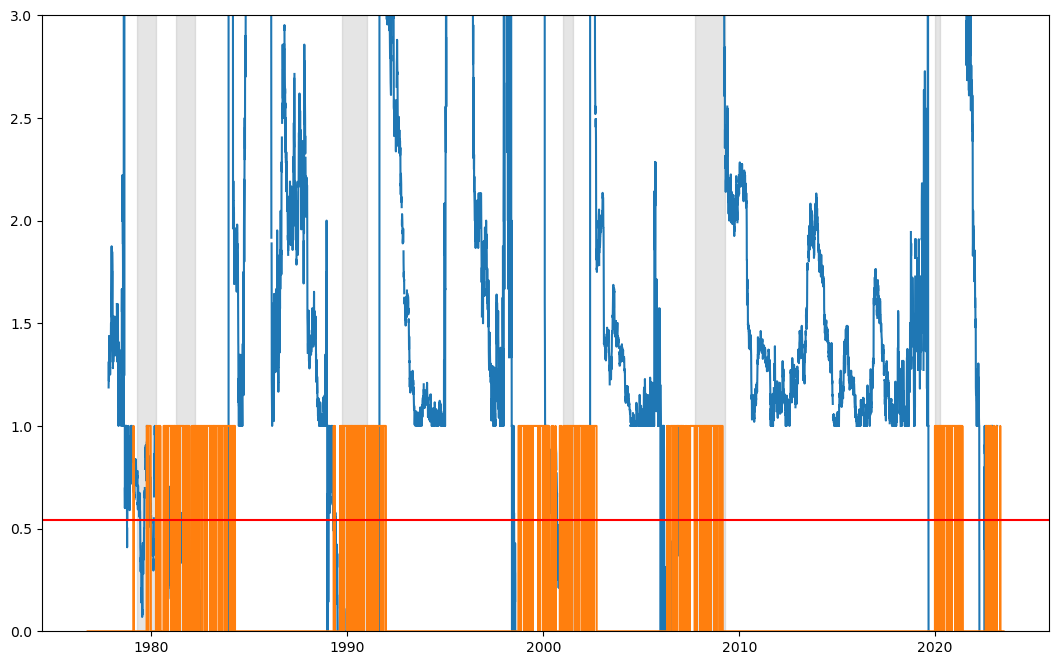

In [10]:
threshold = np.linspace(-20,20,num=75)
final_thres = threshold[38]
print(f"final threshold: {final_thres}")

df2 = df.copy()
df2.index = df2.index + dt.timedelta(days=4*30)

df2['MIN_1Y'] = np.nan
for i in range(len(df2)):
  if i >= 365:
    arr = np.array(df2['T10Y2Y'])
    indices = [i-k for k in range(365)]
    take = np.take(arr, indices)
    df2.iloc[i,1] = take[~np.isnan(take)].min()
  else:
    df2.iloc[i,1] = np.nan
df2['CHG'] = (df2['T10Y2Y'])/df2['MIN_1Y']
li = []
for i in range(len(Reces)):
  li.append(df2.reset_index()['DATE'].apply(lambda x: int((x > Reces.loc[i]['start'])&(x < Reces.loc[i]['end']))))
test = reduce(lambda x,y:x+y, li)
df2['recession'] = test.values.copy()

df2['predict'] = df2['CHG'].apply(lambda x: int(x<final_thres))
fig, ax = plt.subplots(figsize=(13,8))
ax.plot(df.index, df2['CHG'])
ax.plot(df2.index, df2['predict'])
for i in range(len(start)):
  ax.axvspan(start[i], end[i], color='grey', alpha=0.2)
ax.axhline(final_thres, color='red')
plt.ylim(0,3)
plt.show()

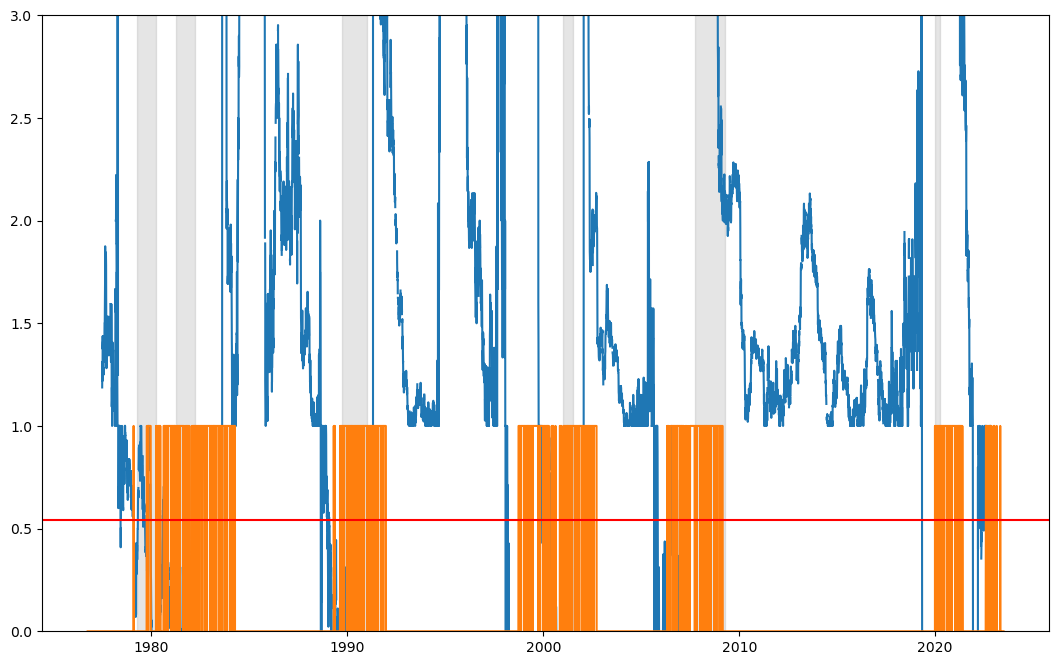

In [11]:
# without time shift for data, (still time shifted prediction)
fig, ax = plt.subplots(figsize=(13,8))
ax.plot(df.index-dt.timedelta(days=4*30), df2['CHG'])
ax.plot(df2.index, df2['predict'])
for i in range(len(start)):
  ax.axvspan(start[i], end[i], color='grey', alpha=0.2)
ax.axhline(final_thres, color='red')
plt.ylim(0,3)
plt.show()

In [13]:
df2['predict'].to_csv('Index1-prediction.csv')